In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")

In [2]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '04f_clustering_visualization'    # name of notebook
save = True

def dump_figure(name):
    if save:
        export.image(
            user,
            f'{outfolder}/{name}',
        )

In [3]:
data = pd.read_csv(
    inout.get_material_path('general/03_overwrite_PF_Cr/03data-external_220901_1010.csv.gz'), 
    index_col=0)

In [4]:
data = data.reset_index()

In [5]:
data_columns = clustering.get_reference_data_columns()

In [6]:
data_mtx_orig = data[data_columns].copy()

# Original data distribution histograms

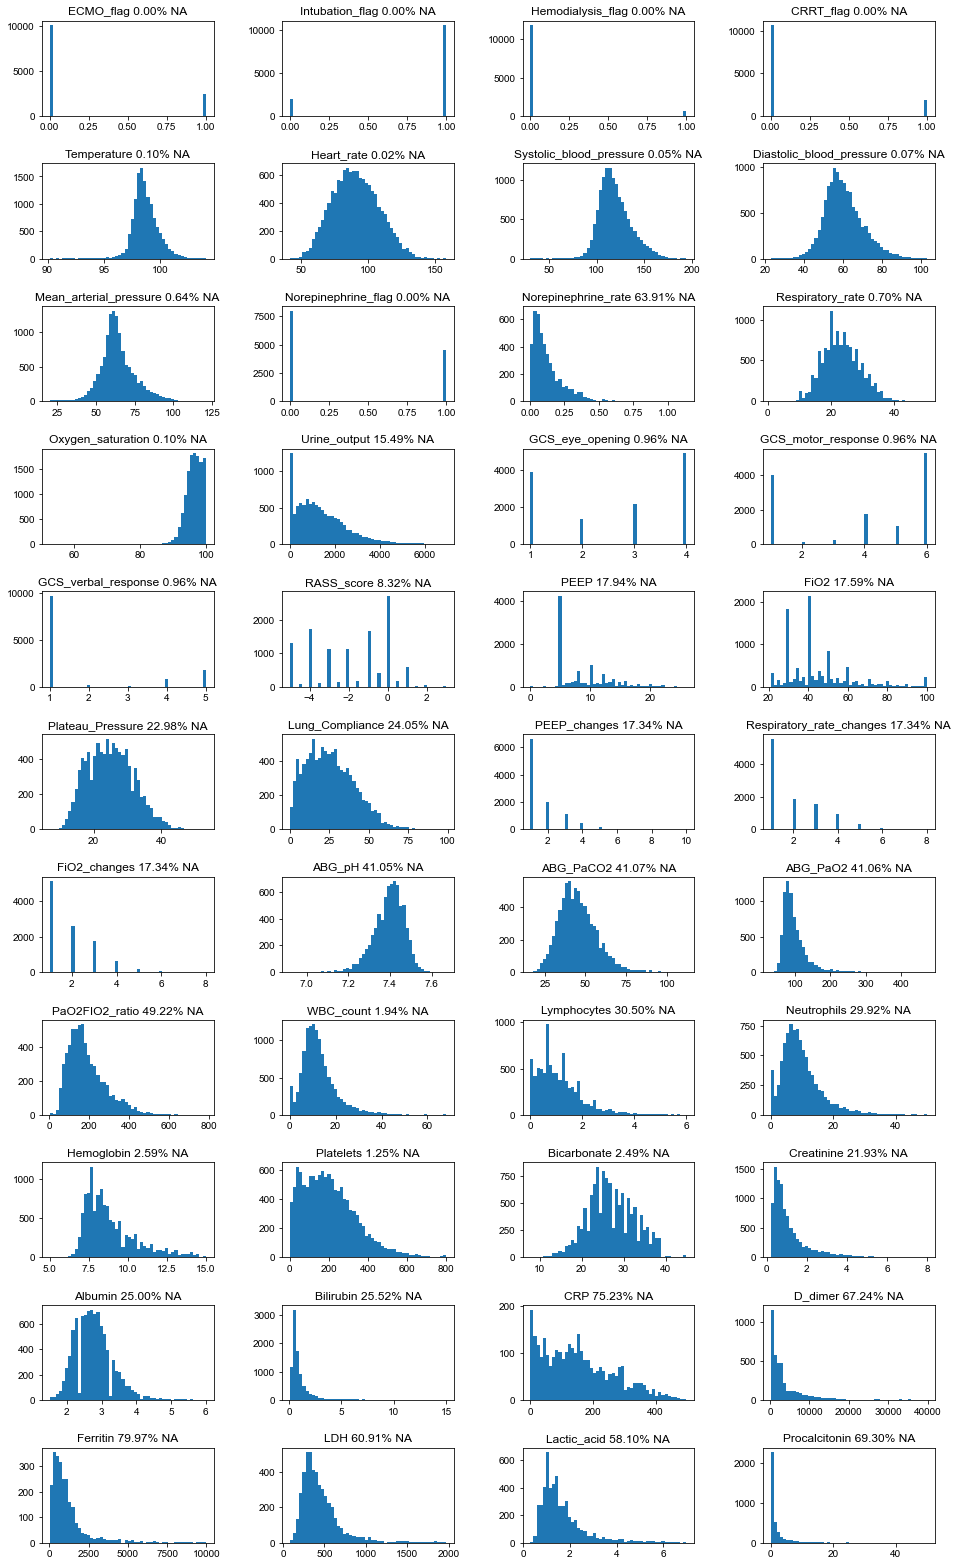

In [8]:
columns = np.array(data_columns)
cols = np.pad(columns, (0, 44 - columns.size), constant_values=np.nan).reshape(11, 4)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=(16, 28), 
    gridspec_kw={"wspace": 0.4, "hspace": 0.5}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        ax = axes[row, col]
        if isinstance(column, str) and column in data:
            ax.hist(
                data[column], 
                bins=50,
#                 log=True
            )
            ax.set_title(column + f" {data[column].isna().sum() * 100 / data.shape[0]:.2f}% NA")
        else:
            ax.remove()
            
dump_figure('original_histograms.pdf')

# Correlation matrix

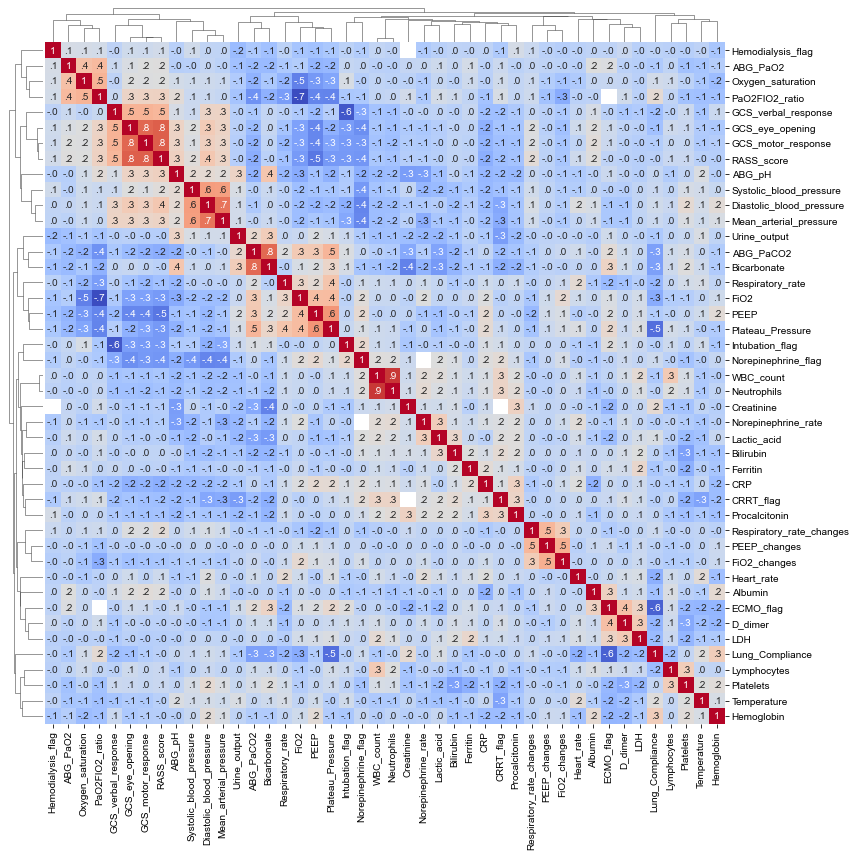

In [11]:
corr_mtx = data[data_columns].corr()
na_idx = corr_mtx.isna()
corr_mtx[na_idx] = 0
cg = sns.clustermap(
    corr_mtx, 
    annot=True, 
    cmap='coolwarm',
    # ax=ax,
    # cbar=None,
    fmt=".1f",
    dendrogram_ratio=0.05,
    cbar_pos=None,
    figsize=(12, 12),
    annot_kws={"size": 10},
    mask=na_idx
)
for t in cg.ax_heatmap.texts:
    val = t.get_text()
    if val == "1.0":
        val = "1"
    else:
        val = val.replace("0", "", 1)
    t.set_text(val)
    
dump_figure('correlation_matrix.pdf')

In [10]:
HIGH_CORR_CUTOFFS = [0.5, 0.6, 0.7, 0.8, 1]
cutoff_groups = {}
for cutoff in HIGH_CORR_CUTOFFS:
    groups = {}
    for c, cols in corr_mtx.apply(lambda x: x.index[(x.abs() > cutoff) & (x.abs() < 1)]).items():
        if cols.size > 0:
            group = None
            if c in groups:
                group = groups[c]
            else:
                for col in cols:
                    if col in groups:
                        group = groups[col]
            if group is None:
                group = []
            group.append(c)
            groups[c] = group
            for col in cols:
                group.append(col)
                groups[col] = group
    for k, v in groups.items():
        groups[k] = tuple(set(v))
    groups = list(set(groups.values()))
    cutoff_groups[cutoff] = groups
cutoff_groups

{0.5: [('Intubation_flag', 'GCS_verbal_response'),
  ('GCS_motor_response', 'RASS_score', 'GCS_eye_opening'),
  ('ABG_PaCO2', 'Bicarbonate'),
  ('Diastolic_blood_pressure',
   'Mean_arterial_pressure',
   'Systolic_blood_pressure'),
  ('WBC_count', 'Neutrophils'),
  ('Plateau_Pressure', 'PEEP', 'Lung_Compliance', 'ECMO_flag'),
  ('PaO2FIO2_ratio', 'FiO2')],
 0.6: [('Intubation_flag', 'GCS_verbal_response'),
  ('GCS_motor_response', 'RASS_score', 'GCS_eye_opening'),
  ('Mean_arterial_pressure', 'Diastolic_blood_pressure'),
  ('ABG_PaCO2', 'Bicarbonate'),
  ('WBC_count', 'Neutrophils'),
  ('PaO2FIO2_ratio', 'FiO2')],
 0.7: [('ABG_PaCO2', 'Bicarbonate'),
  ('GCS_motor_response', 'RASS_score', 'GCS_eye_opening'),
  ('WBC_count', 'Neutrophils'),
  ('Mean_arterial_pressure', 'Diastolic_blood_pressure')],
 0.8: [('WBC_count', 'Neutrophils')],
 1: []}